# Lamb-waves in thin plates

In [1]:
import numpy as np
import sympy as sp
import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import math
import scipy.optimize as opt
import scipy.stats as nst
from scipy.fftpack import fft2
import scipy.ndimage as nim
import scipy.io as sio

sp.init_printing()

EXTENSIE = "pdf"

In [2]:
plt.style.use("presentation")
mpl.rcParams["lines.color"] = "w"
mpl.rcParams["patch.edgecolor"] = "w"
mpl.rcParams["axes.edgecolor"] = "w"
mpl.rcParams["axes.labelcolor"] = "w"
mpl.rcParams["xtick.color"] = "w"
mpl.rcParams["ytick.color"] = "w"
mpl.rcParams["text.color"] = "w"

mpl.rcParams["savefig.facecolor"] = "#37474f"
mpl.rcParams["axes.facecolor"] = "#37474f"
mpl.rcParams["figure.facecolor"] = "#37474f"

%matplotlib notebook

## Constants

In [3]:
ct = 3.18e3 #m/s - velocity of transverse waves
cl = 5.79e3 #m/s - velocity of longitudinal waves
d = 0.001 #m - thickness of the plate

## Verwerken data experiment

### Inladen data

In [4]:
S = sio.loadmat("S.mat")["S"]
f_theorie = S[:,0]
a0_theorie = S[:,1]

In [5]:
displacement_array = np.loadtxt("metingen/Scanpump_Ch1_0_X0.txt")

distance = 50

while distance <= 50050:
    ar = np.loadtxt("metingen/Scanpump_Ch1_0_X%d.txt" %distance)
    displacement_array = np.vstack([displacement_array, ar])
    distance += 50
    if distance % 5000 == 0:
        print(distance)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000


### plotten golf en fourrier-transformatie

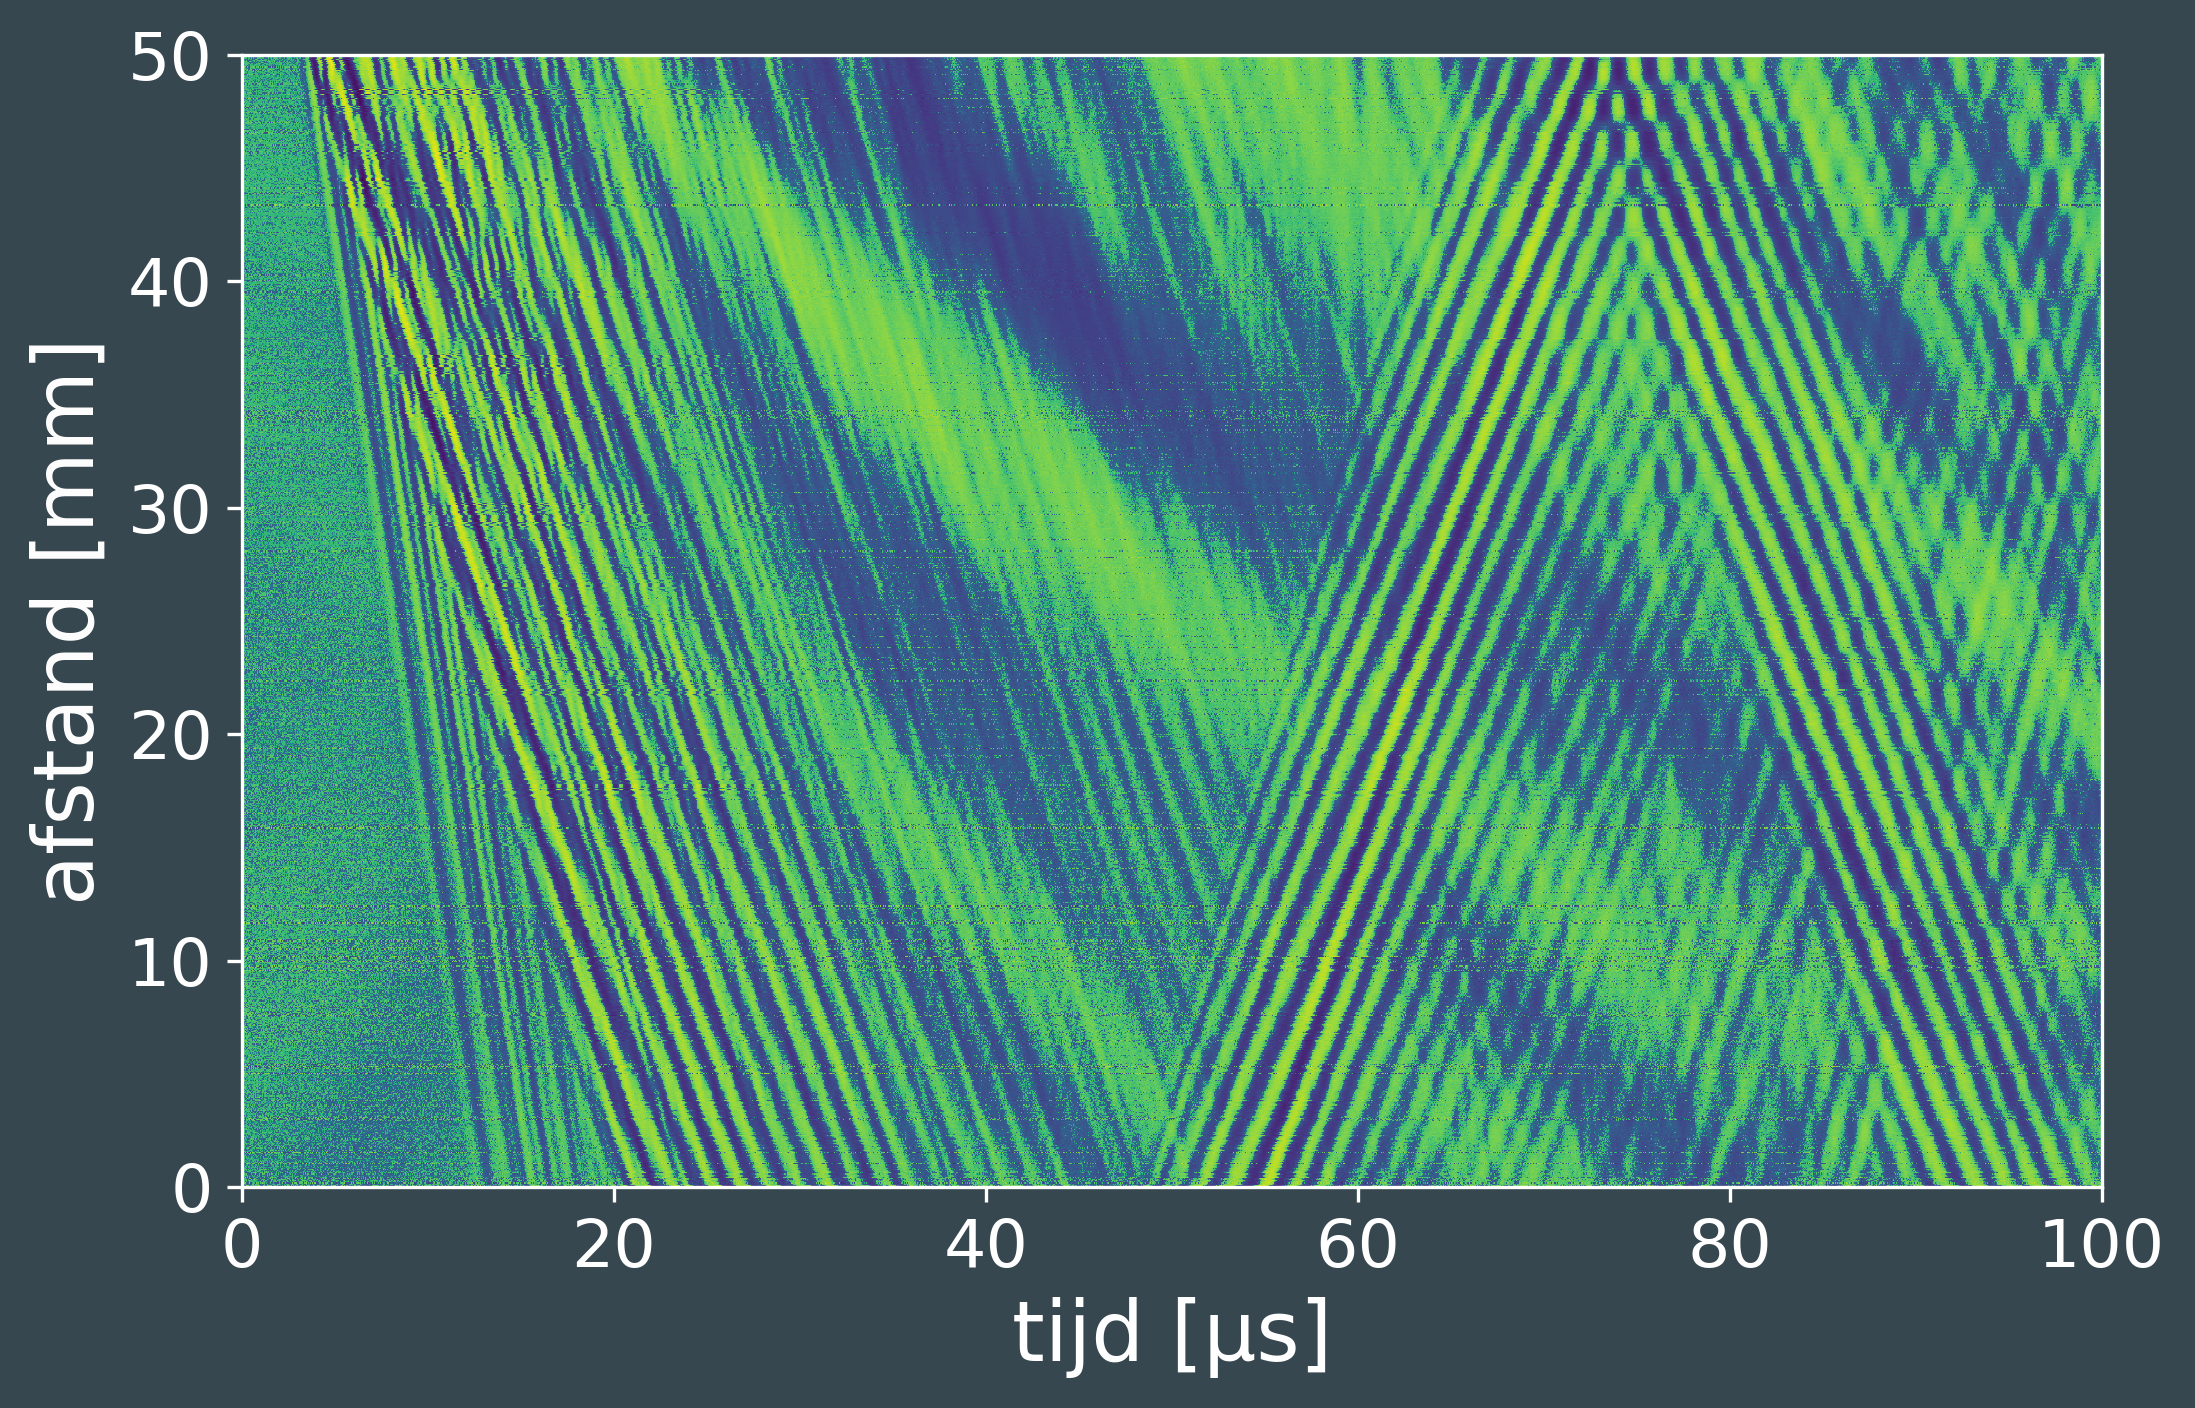

In [6]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

dis = np.sign(displacement_array) * np.abs(displacement_array)**0.25
im = ax.imshow(dis[:,:], aspect='auto', cmap='viridis', interpolation='none', extent=(0, 100, 0, 50))

ax.set_xlabel("tijd [µs]")
ax.set_ylabel("afstand [mm]")
#plt.title("uitwijking plaat")
#fig.colorbar(im)

plt.show()

fig.savefig("ampiltude.png", dpi=600)

In [7]:
f_k = fft2(dis[:,:])
shape = f_k.shape
f_k = np.roll(f_k, shape[0]//2, 0)
f_k = np.roll(f_k, shape[1]//2, 1)

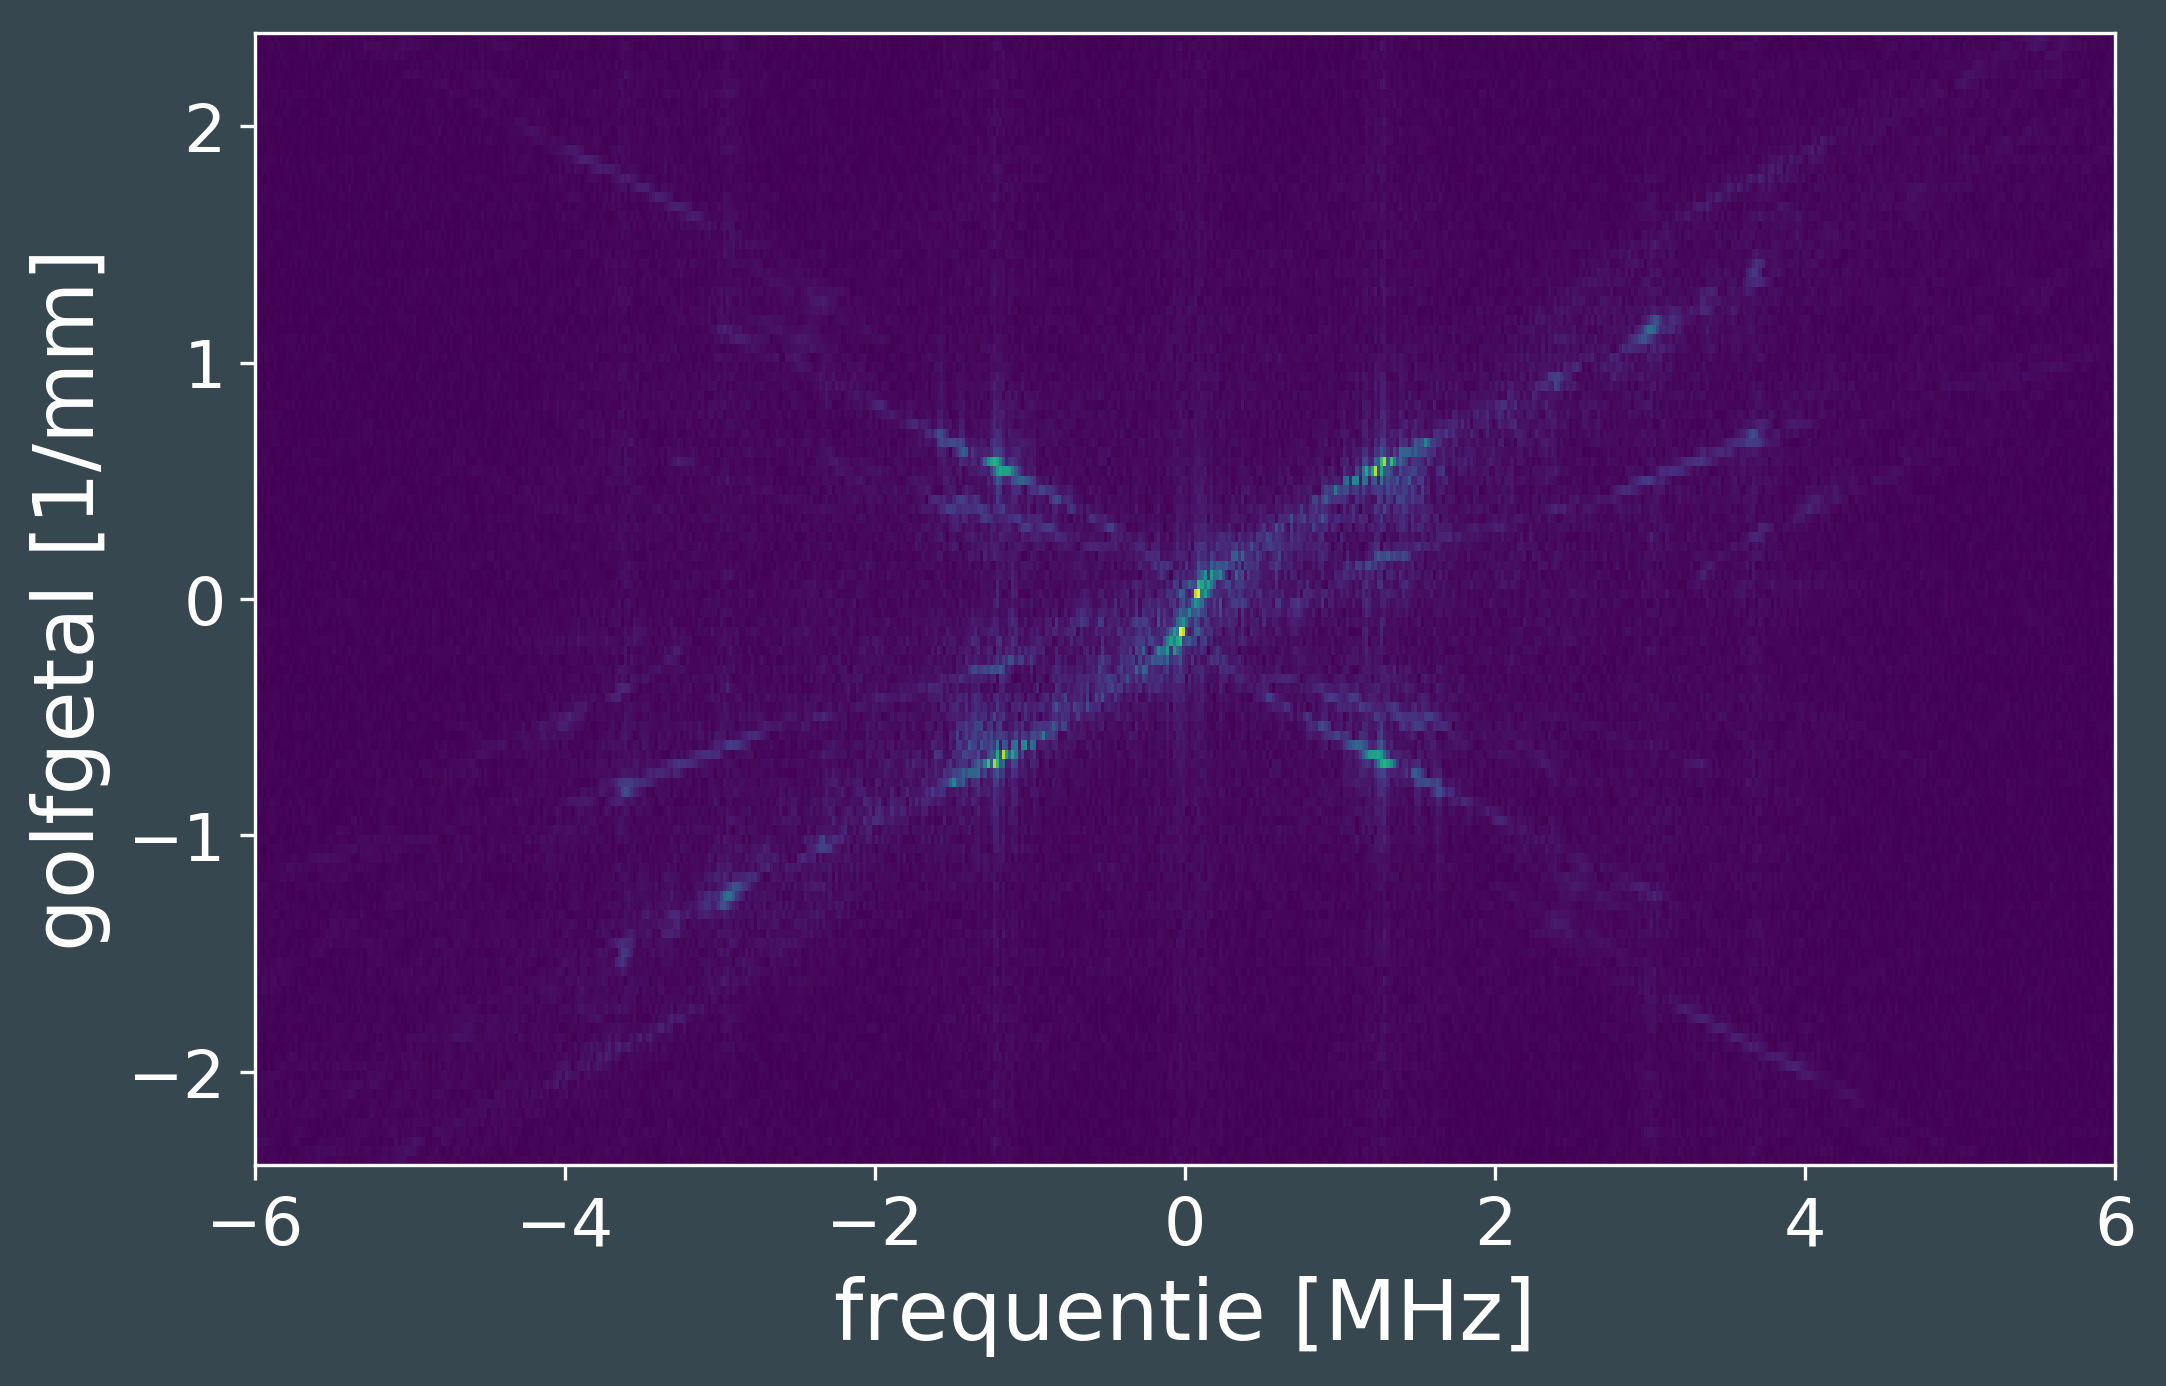

In [8]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

data = np.abs(f_k[440:560, 12200:12800])**0.75
im = ax.imshow(data, aspect='auto', cmap='viridis', interpolation='none',
               extent = (-250/12501*300, 250/12501*300, -20/501*60, 20/501*60))
ax.set_xlabel("frequentie [MHz]")
ax.set_ylabel("golfgetal [1/mm]")

#fig.colorbar(im)

plt.show()

fig.savefig("fourrier transform.png", dpi=600)

### selecteren van sterkste modes en plotten dispersiecurve

bepalen van de grenzen

In [9]:
f_factor = 250e6/12501
k_factor = 2e4/501

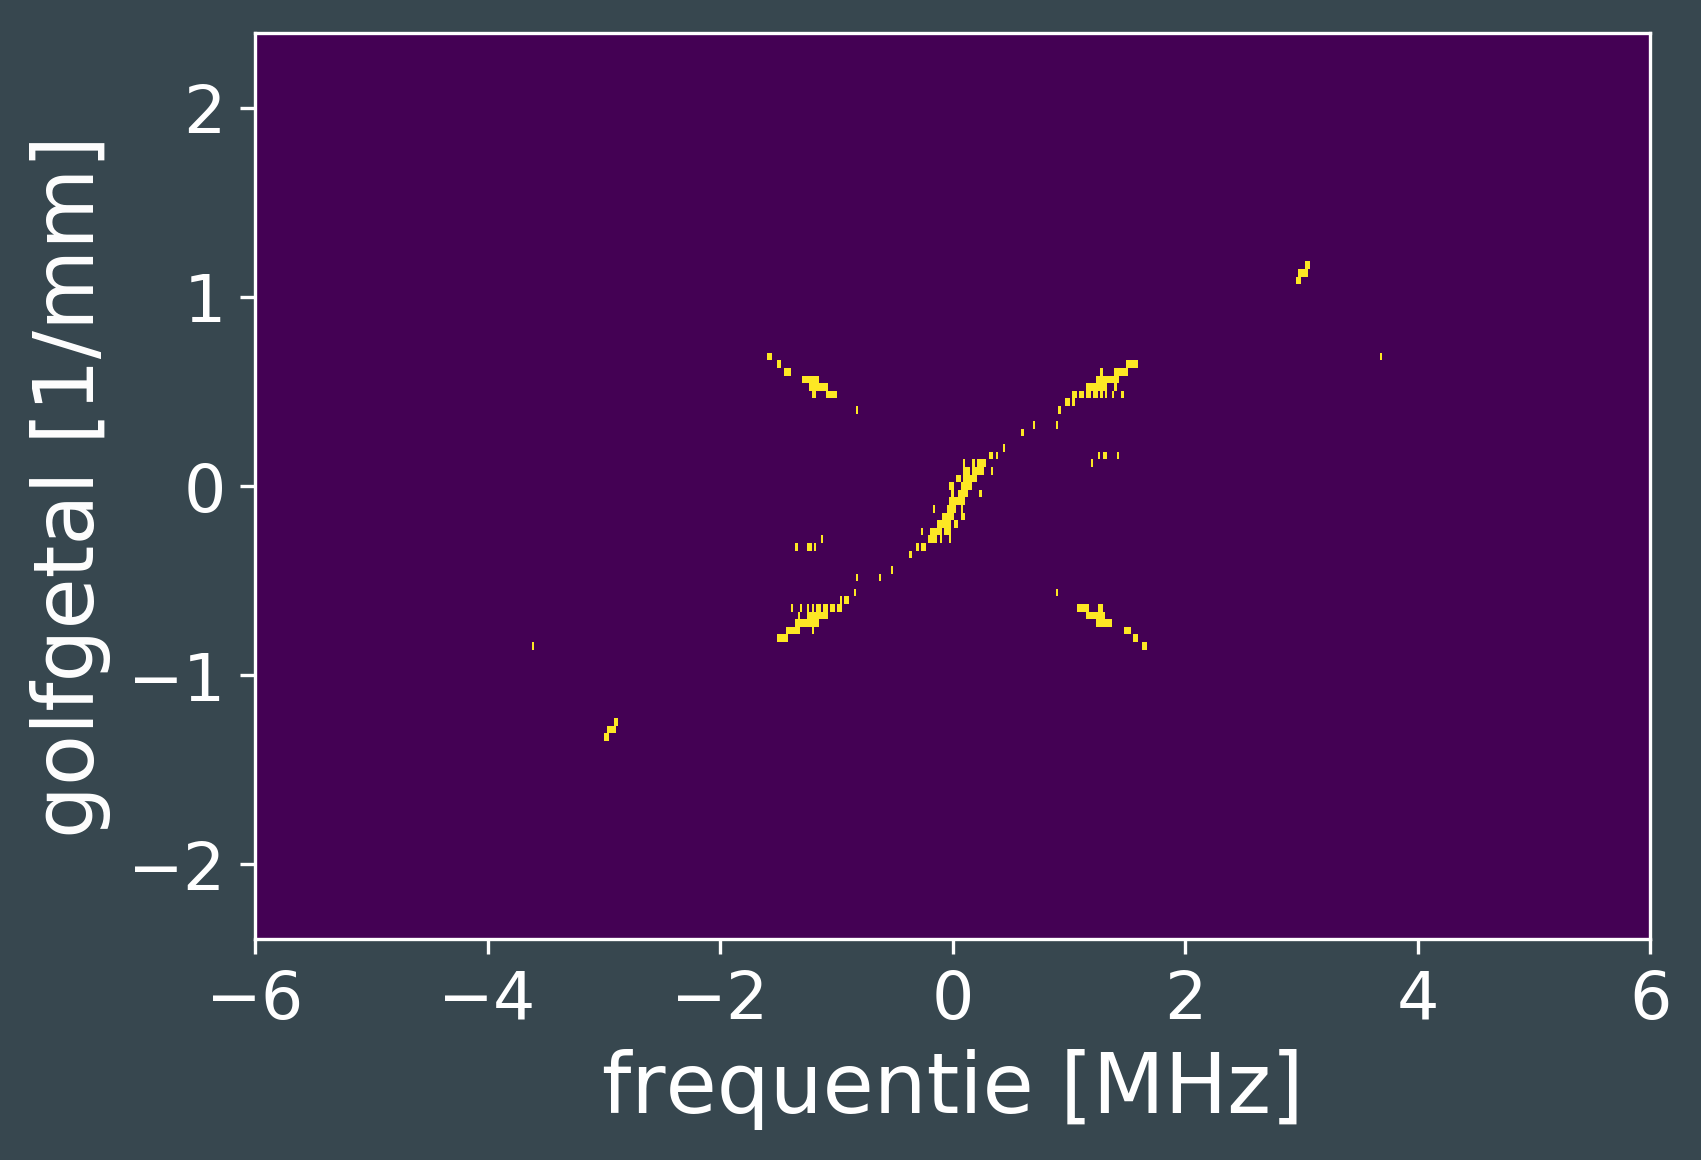

In [10]:
fig, ax = plt.subplots(1,1)

data = np.abs(f_k[440:560-1, 12200:12800-1])**0.75
im = ax.imshow(data > 8500, aspect='auto', cmap='viridis', interpolation='none',
               extent = (-250/12501*300, 250/12501*300, -20/501*60, 20/501*60))
ax.set_xlabel("frequentie [MHz]")
ax.set_ylabel("golfgetal [1/mm]")

#fig.colorbar(im)

plt.show()

#fig.savefig("fourrier transform.png", dpi=1200)

/home/pieter/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/home/pieter/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


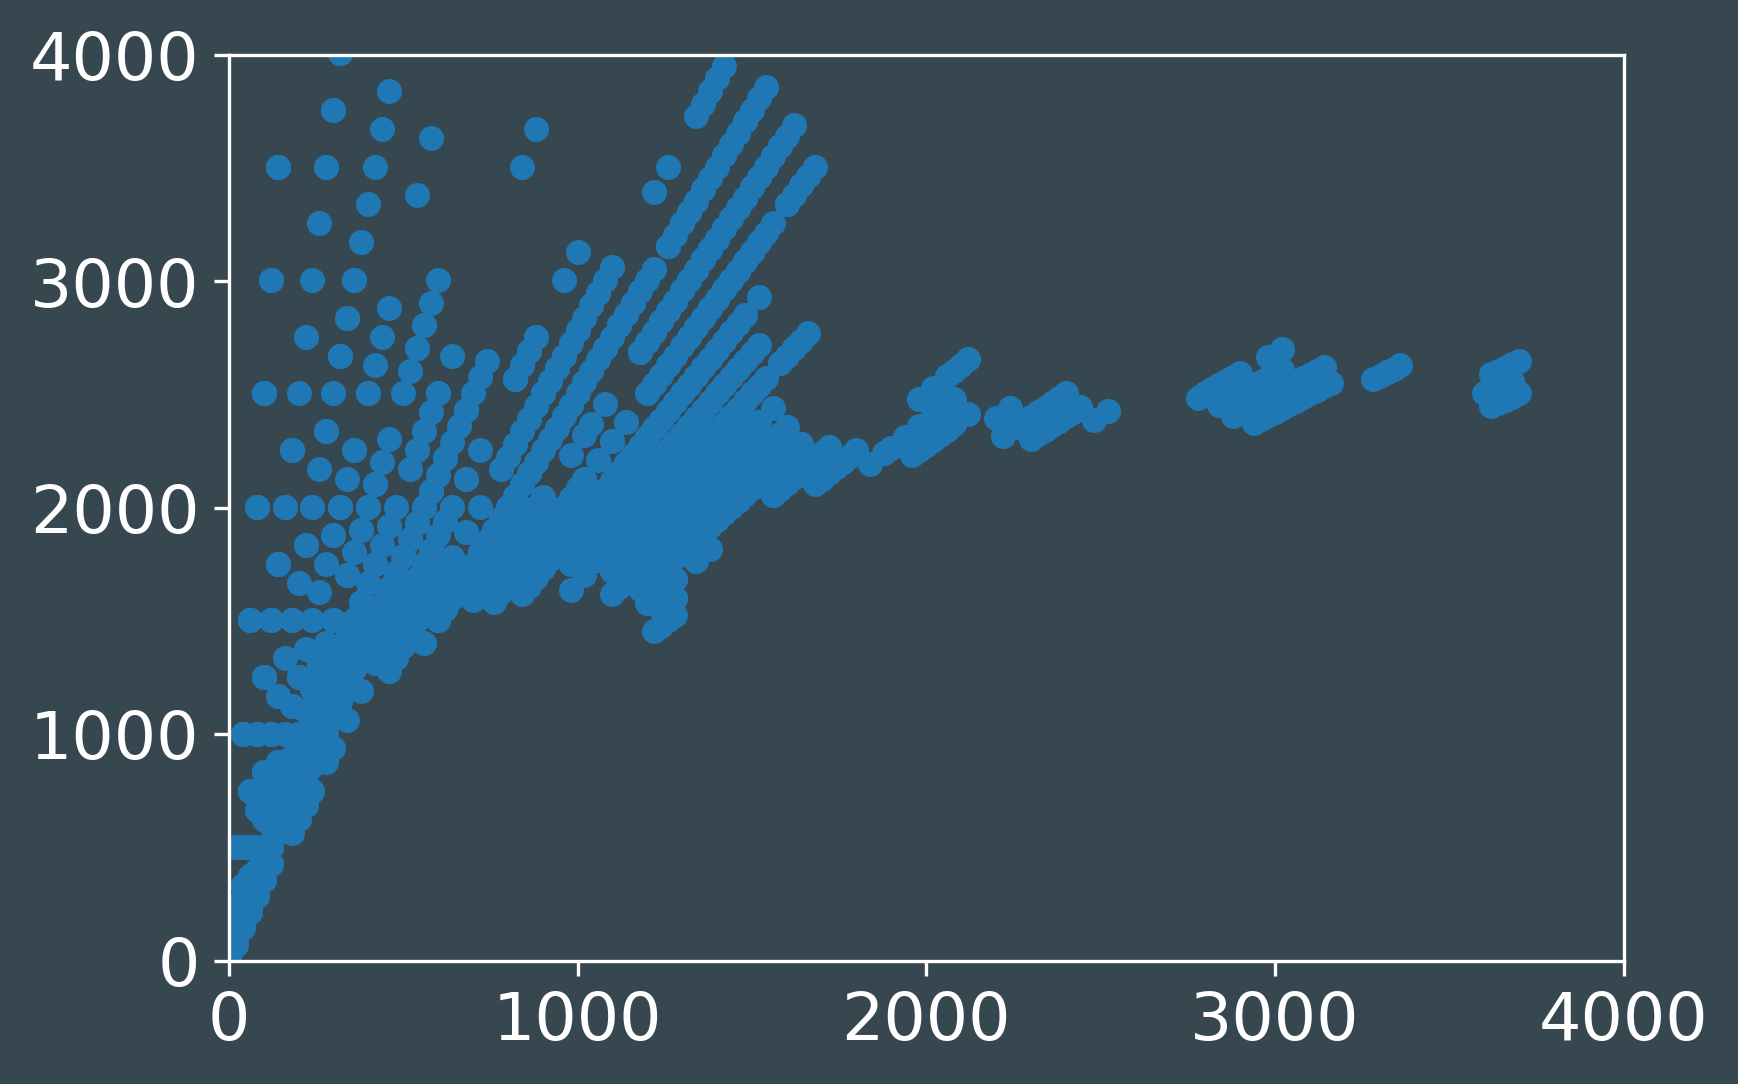

In [11]:
curves = np.where(data > 4000)

F = (curves[1] - 300)*f_factor
K = (curves[0] - 61)*k_factor

fig, ax = plt.subplots(1,1)

ax.plot(np.abs(F*d), np.abs(F/K), '.')
ax.set_xlim(0, 4000)
ax.set_ylim(0, 4000)

plt.show()

/home/pieter/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/pieter/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


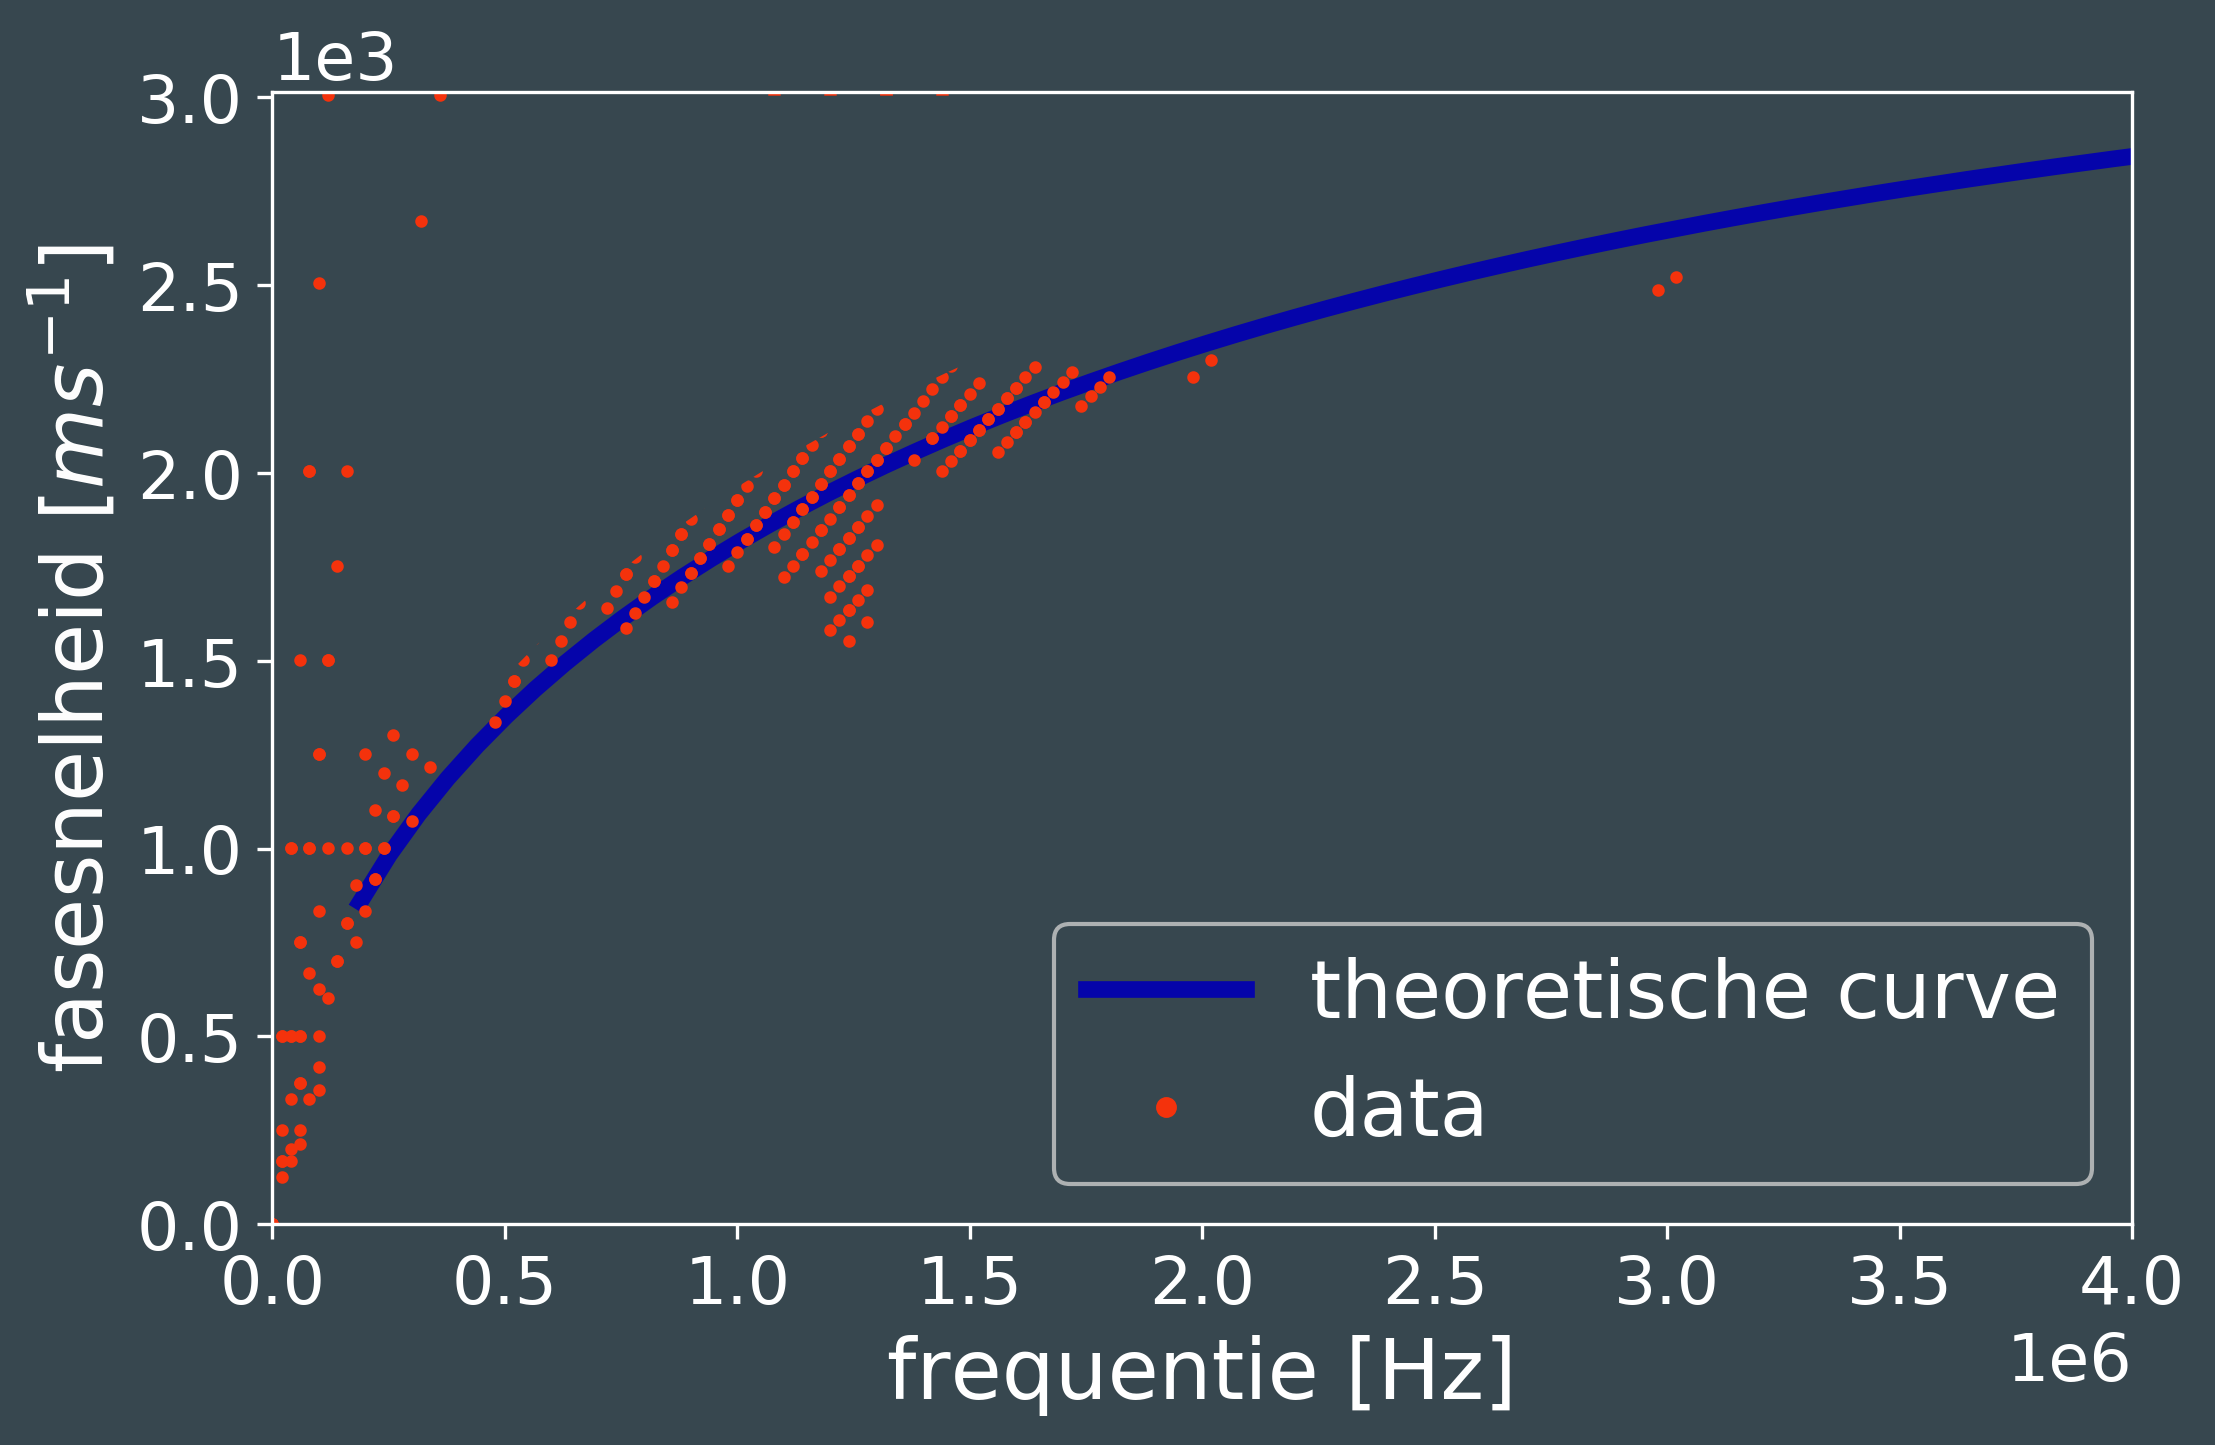

In [15]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.plot(f_theorie[3:]*2*np.pi*1e6, a0_theorie[3:]*1150, label="theoretische curve", 
        color="xkcd:royal blue", linewidth=4)
ax.plot(np.abs(F), F/K, '.', markersize=4, label="data", color="xkcd:vermillion")
ax.fill_between(f_theorie[7:40]*2*np.pi*1e6 - 100, a0_theorie[7:40]*1250, 
                np.ones_like(f_theorie[7:40])*3000, color="#37474f", zorder=3.)

ax.set_xlim(0, 4000/d)
ax.set_ylim(0, 3015)
ax.set_xlabel(r"frequentie [Hz]")
ax.set_ylabel(r"fasesnelheid [$ms^{-1}$]")
#plt.title("Theoretische dispersiekromme en data")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend()

plt.show()

fig.savefig("dispersie_data.png", dpi=600)

## theoretische curves 

In [ ]:
def q2(omega, k):
    return k**2 - omega**2/cl**2 

def s2(omega, k):
    return k**2 - omega**2/ct**2

def S(omega, k):
    Q = q2(omega, k)
    S = s2(omega, k)
    q = np.sqrt(np.abs(Q))
    s = np.sqrt(np.abs(S))
    
    if Q > 0 and S > 0:
        return (k**2 + S)**2 * np.cosh(q*d)*np.sinh(s*d) + 4*k**2*q*s * np.sinh(q*d)*np.cosh(s*d)
    elif S < 0:
        return (k**2 + S)**2 * np.cosh(q*d)*np.sin(s*d) + 4*k**2*q*s * np.sinh(q*d)*np.cos(s*d)
    else:
        return (k**2 + S)**2 * np.cos(q*d)*np.sin(s*d) - 4*k**2*q*s * np.sin(q*d)*np.cos(s*d)

def A(omega, k):
    return lhs(omega, k) - rhs_a(omega, k)

### golfgetal in functie van hoekfrequentie

symetrische curves

In [ ]:
SIDE = 500

extent = (-20e6, 20e6, -12000, 12000)
OMEGA = np.linspace(extent[0], extent[1], SIDE)
K = np.linspace(extent[2], extent[3], SIDE)

grid = np.zeros((SIDE, SIDE))

for x in range(SIDE):
    for y in range(SIDE):
        grid[y, x] = S(OMEGA[x], K[y])

In [ ]:
im = np.sign(grid)

sx = nim.sobel(im, axis=0, mode='constant')
sy = nim.sobel(im, axis=1, mode='constant')
border = np.hypot(sx, sy)

In [ ]:
fig, ax = plt.subplots(1,1)

ax.imshow(np.sign(border), extent=extent, aspect='auto', cmap="viridis")
ax.set_ylabel("golfgetal k [1/m]")
ax.set_xlabel("hoekfrequentie [Hz*rad]")

plt.show()

fig.savefig("theorie:k-omega-S.png", dpi=1200)

assymetrische curves

In [ ]:
grid = np.zeros((SIDE, SIDE))

for x in range(SIDE):
    for y in range(SIDE):
        grid[y, x] = A(OMEGA[x], K[y])

In [ ]:
im = np.sign(grid)

sx = nim.sobel(im, axis=0, mode='constant')
sy = nim.sobel(im, axis=1, mode='constant')
border = np.hypot(sx, sy)

In [ ]:
fig, ax = plt.subplots(1,1)

ax.imshow(border, extent=extent, aspect='auto')
ax.set_ylabel("golfgetal k [1/m]")
ax.set_xlabel("hoekfrequentie [Hz*rad]")

plt.show()

fig.savefig("theorie:k-omega-A.png", dpi=600)

### fasesnelheid in functie van frequentie

Curves voor symmetrische modes

In [ ]:
SIDE = 500

extent = (0, 15e3, 2, 1000)

Fd = np.linspace(extent[0], extent[1], SIDE)
VP = np.linspace(extent[2], extent[3], SIDE)
grid = np.zeros((SIDE, SIDE))

for x in range(SIDE):
    for y in range(SIDE):
        omega = 2*np.pi*Fd[x]/d
        k = F[x]/VP[-(y+1)]
        grid[x, y] = S(omega, k)

In [ ]:
im = np.sign(grid)

sx = nim.sobel(im, axis=0, mode='constant')
sy = nim.sobel(im, axis=1, mode='constant')
border = np.hypot(sx, sy)

In [ ]:
fig, ax = plt.subplots(1,1)

ax.imshow(np.transpose(np.sign(border)), extent=extent, aspect='auto')
ax.set_xlabel("f")
ax.set_ylabel("v_p")

plt.show()

fig.savefig("theorie:f-vp-S.png", dpi=600)

Curves voor asymmetrische modes

In [ ]:
grid = np.zeros((SIDE, SIDE))

for x in range(SIDE):
    for y in range(SIDE):
        omega = 2*np.pi*F[x]
        k = F[x]/VP[-(y+1)]
        grid[x, y] = A(omega, k)

In [ ]:
im = np.sign(grid)

sx = nim.sobel(im, axis=0, mode='constant')
sy = nim.sobel(im, axis=1, mode='constant')
border = np.hypot(sx, sy)

In [ ]:
fig, ax = plt.subplots(1,1)

ax.imshow(np.transpose(border), extent=extent, aspect='auto')
ax.set_xlabel("f")
ax.set_ylabel("v_p")

plt.show()

fig.savefig("theorie:f-vp-A.png", dpi=600)

## Animatie trilling plaat

In [ ]:
# test plotten spacial data
fig, ax = plt.subplots(1,1)

X = np.arange(0.0, 50.100, 0.05)

ax.plot(X, displacement_array[:,10000], linewidth=0.5)

plt.show()

In [ ]:
np.max(displacement_array)

In [ ]:
np.min(displacement_array)

In [ ]:
np.size(displacement_array[:,1])

In [ ]:
STEP = 10
FRAMES = 1000
fig, ax = plt.subplots(1,1)

X = np.arange(0.0, 50.100, 0.05)

curve, = ax.plot(X, displacement_array[:,0], linewidth=0.5)
text = ax.text(0.0, 0.3, "tijd: %.3f µs" %0.0)

ax.set_ylim(-0.37, 0.34)
ax.set_xlabel("afstand [mm]")
ax.set_ylabel("displacement [a.i.]")

def animate(i):
    curve.set_data(X, displacement_array[:,i*STEP])
    text.set_text("tijd: %.3f µs" %(i*STEP/250))
    
anim = animation.FuncAnimation(fig, animate, frames=FRAMES, interval=50)
plt.show()